#Mount Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


#Import packages

In [2]:
import numpy as np
import pandas as pd
import os 

#Paths setting

In [3]:
image_path='/content/gdrive/MyDrive/Personalized_Perception/Experiment_dataset/Cat_dataset/'

#Data Loading

##Loading rating sample experiment participant behavior data

In [4]:
rating_sample_data=np.load('/content/gdrive/MyDrive/Personalized_Perception/Observer experiment result/experiment result/Rating sampled experiment data/Rating sample 2000 result.npy',allow_pickle=True).item()

In [5]:
rating_sample_data.keys()

dict_keys(['Eddy', 'Jack Lo'])

In [6]:
participant=list(rating_sample_data.keys())[1]

In [7]:
classes_distribution={}
class_imgs={}
for img,value in rating_sample_data[participant].items():
  if str(value) not in classes_distribution.keys():
    classes_distribution[f'{value}']=1
    class_imgs[f'{value}']=[img]
  else:
    classes_distribution[f'{value}']+=1
    class_imgs[f'{value}'].append(img)

In [8]:
classes_distribution

{'1.0': 202,
 '2.0': 407,
 '3.0': 487,
 '4.0': 354,
 '5.0': 313,
 '6.0': 158,
 '7.0': 79}

In [9]:
#Loading rating W latent space map
w_latent_space=np.load(r'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Image latent space data/W/rating_experiment_2000_image_W_latent_space_data_map.npy',allow_pickle=True).item()

#Loading pre-trained linear svm



##Load SVM model

In [10]:
import joblib

In [11]:
clf=joblib.load(f'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/SVM/{participant}/{participant}_rating_experiment.joblib') 

#Regenerate image from StyleGan2 ADA

##Load StyleGAN-ada Genertor

Download StyleGAN-ada afhqcat model

In [12]:
%tensorflow_version 1.x
# ! pip install torch==1.7.1+cu110 torchvision==0.8.2+cu110 torchaudio==0.7.2 -f https://download.pytorch.org/whl/torch_stable.html 

After that, `%tensorflow_version 1.x` will throw an error.

Your notebook should be updated to use Tensorflow 2.
See the guide at https://www.tensorflow.org/guide/migrate#migrate-from-tensorflow-1x-to-tensorflow-2.

TensorFlow 1.x selected.


In [13]:
import os
os.chdir('/content')
CODE_DIR = 'stylegan2-ada'

!git clone https://github.com/NVlabs/stylegan2-ada.git $CODE_DIR

Cloning into 'stylegan2-ada'...
remote: Enumerating objects: 74, done.
remote: Total 74 (delta 0), reused 0 (delta 0), pack-reused 74
Unpacking objects: 100% (74/74), done.


In [14]:
%cd /content/stylegan2-ada
import argparse
import os
import pickle
import re

import numpy as np
import PIL.Image

import dnnlib
import dnnlib.tflib as tflib
tflib.init_tf()
print('Loading networks from "%s"...' % 'https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqcat.pkl')
with dnnlib.util.open_url('https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqcat.pkl') as fp:
        _G, _D, Gs = pickle.load(fp)

/content/stylegan2-ada
Loading networks from "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada/pretrained/afhqcat.pkl"...


#Load VGG-19bn model to evaluate the image still be considered as cat

In [33]:
os.chdir('/content')

In [21]:
import torch

model = torch.hub.load('pytorch/vision:v0.10.0', 'vgg19_bn', pretrained=True)
model.eval()

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
Downloading: "https://download.pytorch.org/models/vgg19_bn-c79401a0.pth" to /root/.cache/torch/hub/checkpoints/vgg19_bn-c79401a0.pth


  0%|          | 0.00/548M [00:00<?, ?B/s]

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (5): ReLU(inplace=True)
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (7): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (9): ReLU(inplace=True)
    (10): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): ReLU(inplace=True)
    (13): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (14): Conv2d(128, 256

In [31]:
# Download ImageNet labels
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-07-17 17:24:12--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-07-17 17:24:12 (52.7 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [23]:
# sample execution (requires torchvision)
from PIL import Image
from torchvision import transforms

def pre_processing(img):
  input_image = Image.fromarray(img)
  preprocess = transforms.Compose([
      transforms.Resize(256),
      transforms.CenterCrop(224),
      transforms.ToTensor(),
      transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
  ])
  input_tensor = preprocess(input_image)
  input_batch = input_tensor.unsqueeze(0) # create a mini-batch as expected by the model

  # move the input and model to GPU for speed if available
  if torch.cuda.is_available():
      input_batch = input_batch.to('cuda')
      model.to('cuda')

  with torch.no_grad():
      output = model(input_batch)
  # Tensor of shape 1000, with confidence scores over Imagenet's 1000 classes
  # print(output[0])
  # The output has unnormalized scores. To get probabilities, you can run a softmax on it.
  probabilities = torch.nn.functional.softmax(output[0], dim=0)
  return probabilities

In [24]:
#define cat species in VGG
cat_species=['tabby','tiger cat','Persian cat','Siamese cat','Egyptian cat','lynx']

In [32]:
# Read the categories
with open("imagenet_classes.txt", "r") as f:
  categories = [s.strip() for s in f.readlines()]

##Function for style_morphing

In [15]:
from PIL import Image

In [16]:
def reconstruct_latent_space(latent):
  reconstructed_latent=np.zeros((1,18,512))
  for i in range(len(reconstructed_latent[0])):
      reconstructed_latent[0][i]=latent
  return reconstructed_latent


In [26]:
def style_morphing(initial_img_latent_space, style_dir, steps, make_cuter):
  """
  Input:
    initial_img_latent_space -> numpy array [512,] shape: the image's W latent space from pSp encoder
    style_dir -> numpy array [512,] shape: the reconstructed SVM coef
    steps -> int: the morphing steps
    make_cuter -> bool: make the image cuter or uglier
  Output:
    morghing_imgs -> numpy array [steps,512,512,3] shape: regenerated image matrix
  """
  if make_cuter:
    target_latent_space=reconstruct_latent_space(style_dir)+reconstruct_latent_space(initial_img_latent_space)
  else:
    target_latent_space=reconstruct_latent_space(-style_dir)+reconstruct_latent_space(initial_img_latent_space)

  latent_morphing=np.linspace(initial_img_latent_space, target_latent_space, num=steps)
  
  morghing_imgs=[]
  for latent_space in latent_morphing:
    traget_img=Gs.components.synthesis.run(latent_space, output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:] # generate image based on modified latent space
    probabilities=pre_processing(traget_img) # processing VGG evalueation 
    top1_prob, top1_catid = torch.topk(probabilities, 1) 
    print(categories[top1_catid],top1_prob[0].item()) # print the confidentest VGG evalueation
    if categories[top1_catid] not in cat_species: # if the confidentest result is not consider in cat_specieses
      break
    morghing_imgs.append(traget_img) 
  print(np.array(morghing_imgs).shape) 
  return np.array(morghing_imgs)

##Define style_dir of cuteness

In [17]:
style_dir=clf.coef_[0]

## random collecting neutral samples from individual

In [18]:
neutral_data={} # recording all neutral samples' w_latent_space
for img in class_imgs['4.0']:
  neutral_data[img[7:]]=w_latent_space[img[7:]][0,0]
distance_data=clf.decision_function(np.array(list(neutral_data.values())))

np.random.seed(2022)

neutral_data_keys=np.random.choice(class_imgs['4.0'],60,replace=False)
neutral_data_keys=np.array([s[7:] for s in neutral_data_keys])

### Style Manipulation one image

In [27]:
sample_index=2
image=Image.open(image_path+neutral_data_keys[sample_index])

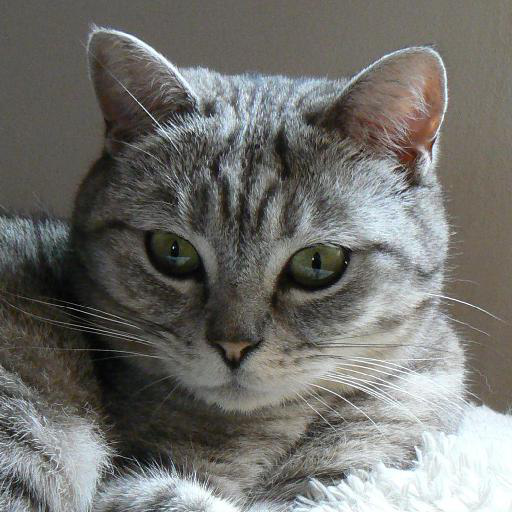

In [28]:
image

In [34]:
transformed_img=style_morphing(neutral_data[neutral_data_keys[sample_index]],style_dir,steps=5,make_cuter=True)

Egyptian cat 0.7187023758888245
Egyptian cat 0.8699654340744019
Egyptian cat 0.940824031829834
Egyptian cat 0.8650966882705688
Egyptian cat 0.763586699962616
(5, 512, 512, 3)


In [35]:
image_list=transformed_img[0]
result_images=[]
result=[]
for i in range(1,len(transformed_img),1):
  image_list=np.concatenate([image_list,transformed_img[i]], axis=1)
  result_images.append(transformed_img[i])
result.append(Image.fromarray(image_list))

In [36]:
result[0]

Output hidden; open in https://colab.research.google.com to view.

# Create folder for storing the validation images

In [ ]:
os.makedirs(rf'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/SVM/{participant}/Validation_image/',exist_ok=True)
os.makedirs(rf'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/SVM/{participant}/Validation_image/original_image/',exist_ok=True)
os.makedirs(rf'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/SVM/{participant}/Validation_image/transformed_image/',exist_ok=True)
os.makedirs(rf'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/SVM/{participant}/Validation_image/transformed_image/',exist_ok=True)


# Storing the validataion images

## Storing the final style manipulated image for validataion

In [ ]:
for idx,img_name in enumerate(neutral_data_keys):
  print(img_name)
  image=Image.open(image_path+img_name)
  image.save(rf'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/SVM/{participant}/Validation_image/original_image/{img_name[:-4]}.png')
  if idx < len(neutral_data_keys)//2:
    transformed_img=Image.fromarray(style_morphing(neutral_data[img_name],style_dir,5,make_cuter=True)[-1])
    transformed_img.save(rf'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/SVM/{participant}/Validation_image/transformed_image/{img_name[:-4]}_make_cuter.png')
  else:
    transformed_img=Image.fromarray(style_morphing(neutral_data[img_name],style_dir,5,make_cuter=False)[-1])
    transformed_img.save(rf'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/SVM/{participant}/Validation_image/transformed_image/{img_name[:-4]}_make_uglier.png')


pixabay_cat_000548.jpg
tabby 0.6455001831054688
tabby 0.5737297534942627
tabby 0.5170413255691528
tabby 0.4653904438018799
tiger cat 0.493503600358963
(5, 512, 512, 3)
pixabay_cat_003665.jpg
tabby 0.584360659122467
tabby 0.5236190557479858
tabby 0.4535456597805023
tabby 0.3842237889766693
Egyptian cat 0.529649555683136
(5, 512, 512, 3)
pixabay_cat_000223.jpg
Egyptian cat 0.1887296736240387
Egyptian cat 0.3799394965171814
Egyptian cat 0.5464401245117188
Egyptian cat 0.4317816495895386
Egyptian cat 0.23955482244491577
(5, 512, 512, 3)
pixabay_cat_000258.jpg
tiger cat 0.4142739176750183
tiger cat 0.3576200604438782
Egyptian cat 0.37727561593055725
Egyptian cat 0.33773648738861084
Egyptian cat 0.3956512212753296
(5, 512, 512, 3)
flickr_cat_000470.jpg
tabby 0.6052117943763733
tabby 0.4962015151977539
tabby 0.3869868814945221
tabby 0.406551331281662
Egyptian cat 0.4119102656841278
(5, 512, 512, 3)
pixabay_cat_004383.jpg
Egyptian cat 0.3246203064918518
Egyptian cat 0.20986628532409668
Egyptia

## Storing the style manipulated image list

In [ ]:
for idx,img_name in enumerate(neutral_data_keys):
  image=plt.imread(image_path+img_name)
  # print(image.shape)
  regenerate_img=Gs.components.synthesis.run(reconstruct_latent_space(neutral_data[img_name]), output_transform=dict(func=tflib.convert_images_to_uint8, nchw_to_nhwc=True))[0,:]
  if idx < len(neutral_data_keys)//2:
    transformed_img=Image.fromarray(style_morphing(neutral_data[img_name],style_dir,5,make_cuter=True))
    transformed_img.save(rf'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/SVM/{participant}/Validation_image/transformed_image/{img_name[:-4]}_make_cuter.png')
  else:
    transformed_img=Image.fromarray(style_morphing(neutral_data[img_name],style_dir,5,make_cuter=False))
    transformed_img.save(rf'/content/gdrive/MyDrive/Personalized_Perception/pSp_encoder_research_2022Spring/Machine Learning model experiment with W latent space/SVM/{participant}/Validation_image/transformed_image/{img_name[:-4]}_make_uglier.png')
  plt.imshow(np.concatenate([image,regenerate_imgtransformed_img],axis=1))
  plt.show()